<a href="https://colab.research.google.com/github/Private-ML/gan/blob/master/SimpleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

TRAIN_BATCH_SIZE = 100

In [0]:
from google.colab import drive
drive.mount("/content/drive/")

In [0]:
gen_file = "/content/drive/My Drive/State_of_the_art_2019/gan/generator.pt"
disc_file = "/content/drive/My Drive/State_of_the_art_2019/gan/discriminator.pt"
trans_file = "/content/drive/My Drive/State_of_the_art_2019/gan/transformer"
gen = torch.load(gen_file)
disc = torch.load(disc_file)
with open(trans_file, 'rb') as f:
  transformer = pickle.load(f)

In [0]:
LATENT_DIM = 30
TRAIN_BATCH_SIZE = 1024
FEATURES = 31

In [0]:
gen_over = nn.Sequential(nn.Linear(LATENT_DIM, 27), nn.ReLU(),
                    nn.Linear(27, 27), nn.ReLU(),
                    nn.Linear(27, FEATURES)).cuda()
gen_opt = torch.optim.RMSprop(gen_over.parameters(), lr=1e-3)
gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(gen_opt, milestones=[10000, 30000], gamma=0.1)

In [0]:
disc_over = nn.Sequential(nn.Linear(FEATURES, 34), nn.ReLU(),
                     nn.Linear(34, 32), nn.ReLU(),
                     nn.Linear(32, 27), nn.ReLU(),
                     nn.Linear(27, 1)).cuda()

disc_opt = torch.optim.RMSprop(disc_over.parameters(), lr=1e-3)
disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(disc_opt, milestones=[10000, 30000], gamma=0.1)

In [0]:
def sample_real_gen(batch_size):
  ids = np.random.choice(len(train), size=batch_size)
  return torch.tensor(train[ids], device="cuda", dtype=torch.float)

def sample_gen_data(batch_size):
  noise = torch.rand(batch_size, LATENT_DIM, device="cuda")
  return gen_over(noise)

In [0]:
noise = torch.rand(TRAIN_BATCH_SIZE * 100, LATENT_DIM, device="cuda")
data = np.array(gen(noise).cpu().detach().numpy())
train, test = train_test_split(data, test_size=0.1)

In [0]:
def calc_gradient_penalty_classic(critic:torch.nn.Module,
                                  real_data:torch.Tensor,
                                  fake_data:torch.Tensor):
  assert real_data.shape == fake_data.shape
  alpha = torch.rand(real_data.shape[0], 1)
  alpha = alpha.expand(real_data.size()).cuda()

  interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).cuda()
  interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

  disc_interpolates = critic(interpolates)

  gradients = torch.autograd.grad(
      outputs=disc_interpolates, inputs=interpolates,
      grad_outputs=torch.ones(disc_interpolates.size(), device="cuda"),
      create_graph=True, retain_graph=True, only_inputs=True)[0]

  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
  return gradient_penalty

In [0]:
LAMBDA = 1.
def train_disc(gan_type="WGAN-GP"):
    real_data = sample_real_gen(TRAIN_BATCH_SIZE)
    gen_data = sample_gen_data(TRAIN_BATCH_SIZE)
    
    if gan_type == "JS":
      disc_loss = -logsigmoid(disc_over(
              real_data
          )).mean() - \
          logsigmoid(-disc_over(
              gen_data
          )).mean()
    elif gan_type == "WGAN-GP":
      disc_loss = -(disc_over(
              real_data
          )).mean() - \
          (-disc_over(
              gen_data
          )).mean() + \
                  calc_gradient_penalty_classic(disc_over, real_data, gen_data)*LAMBDA
    else:
      raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP")
    
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss

In [0]:
def train_gen(gan_type="WGAN-GP"):
    gen_data = sample_gen_data(TRAIN_BATCH_SIZE)
    
    if gan_type == "JS":
      gen_loss = -logsigmoid(disc_over(
              gen_data
          )).mean()
    elif gan_type == "WGAN-GP":
      gen_loss = -(disc_over(
              gen_data
          )).mean()
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
TENSORBOARD_LOGDIR = "./logs"
MODEL_NAME = "DIRCv16"
summary_writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOGDIR, MODEL_NAME))

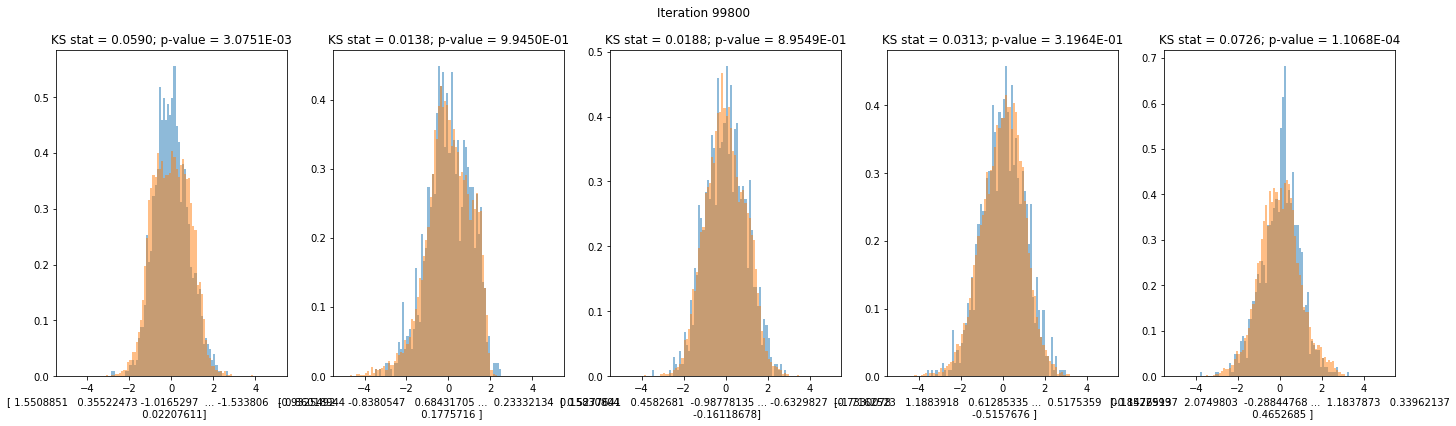

In [25]:
from torch.nn.functional import logsigmoid
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
VALIDATION_INTERVAL = 200
HIST_BINS=100
DATA_HIST_RANGE=[-5, 5]

data_linspace_np = np.linspace(0, 10, num=1024, dtype=np.float32)
data_linspace_torch = torch.from_numpy(data_linspace_np)[:, None].cuda()
validation_data = torch.from_numpy(test).cuda()
validation_data_np = test
validation_x = validation_data[:, FEATURES:]

for i in range(100000):
    gen_scheduler.step()
    disc_scheduler.step()
    for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
        disc_loss_this_iter = train_disc()
    
    gen_loss_this_iter = train_gen()
    summary_writer.add_scalar("discriminator loss", disc_loss_this_iter,
                              global_step=i)
    summary_writer.add_scalar("generator loss", gen_loss_this_iter,
                              global_step=i)
    if i % VALIDATION_INTERVAL == 0:
        clear_output(True)        
        validation_generated = sample_gen_data(TRAIN_BATCH_SIZE)
        validation_generated_np = validation_generated.data.cpu().numpy()
        
        fig, axes_list = plt.subplots(ncols=5, figsize=[6*4, 6])
        for index, ax in enumerate(axes_list):
          ax.hist(validation_generated_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Generated', bins=HIST_BINS)
          ax.hist(validation_data_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Real', bins=HIST_BINS)
          ax.set_xlabel(data[:, index])
          ks_result = ks_2samp(validation_generated_np[:, index],
                                    validation_data_np[:, index])
          ax.set_title("KS stat = {:.4f}; p-value = {:.4E}".format(*tuple(ks_result)))
        fig.suptitle("Iteration {}".format(i))
        plt.show()